In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Setup numeric representation of transitions and values

In [2]:
sentiment_to_numeric = {"negative": 3,  "neutral": 5,  "positive": 9}
# numeric_to_sentiment = {3: "negative",  5: "neutral",  9: "positive"}
numeric_to_echo_transitions = {3: "negative_to_negative",  5: "neutral_to_neutral",  9: "positive_to_positive"}

In [3]:
nr_diffs = []
for ustr in sentiment_to_numeric.keys():
    uval = sentiment_to_numeric[ustr]
    for vstr in sentiment_to_numeric.keys():
        vval = sentiment_to_numeric[vstr]
        if ustr == vstr:
            continue
        nr_diffs.append([uval - vval, uval, vval, ustr, vstr, f"{ustr}_to_{vstr}"])
nr_diffs = pd.DataFrame(nr_diffs, columns=["fdiff", "from", "to", "from_str", "to_str", "transition"])
nr_diffs

,fdiff,from,to,from_str,to_str,transition
0,-2,3,5,negative,neutral,negative_to_neutral
1,-6,3,9,negative,positive,negative_to_positive
2,2,5,3,neutral,negative,neutral_to_negative
3,-4,5,9,neutral,positive,neutral_to_positive
4,6,9,3,positive,negative,positive_to_negative
5,4,9,5,positive,neutral,positive_to_neutral


In [4]:
fdiff_to_transition = nr_diffs.set_index("fdiff")["transition"].to_dict()

## 2. Read data and validate Sentiment values

In [5]:
datadf = pd.read_csv("C:/Users/pog66/Downloads/full_isarel_112top_users.csv", parse_dates=["Date"], usecols=["Date", "Author", "Sentiment"])
datadf.sort_values("Date", inplace=True)
datadf

,Date,Author,Sentiment
35257,2023-10-06 03:24:40,ArtVandelay2021,negative
35256,2023-10-06 04:45:07,Reuters,neutral
35255,2023-10-06 06:21:36,ArtVandelay2021,negative
35254,2023-10-06 07:02:33,realTuckFrumper,neutral
35253,2023-10-06 07:03:03,BrettDGilman,neutral
...,...,...,...
4,2023-10-20 23:57:37,dcexaminer,negative
3,2023-10-20 23:58:06,BaronianConsult,neutral
2,2023-10-20 23:58:21,BaronianConsult,negative
1,2023-10-20 23:58:55,BaronianConsult,neutral


### 2.2. Filter the SENTIMENTS ( e.g. remove Positive sentiment )

In [6]:
# remove positive sentiment for now by removing all authors who have positive sentiments
positive_authors = set(datadf[datadf["Sentiment"] == "positive"]["Author"].unique())
datadf.drop(datadf[datadf["Author"].isin(positive_authors)].index, inplace=True)
datadf

,Date,Author,Sentiment
35257,2023-10-06 03:24:40,ArtVandelay2021,negative
35256,2023-10-06 04:45:07,Reuters,neutral
35255,2023-10-06 06:21:36,ArtVandelay2021,negative
35253,2023-10-06 07:03:03,BrettDGilman,neutral
35252,2023-10-06 08:46:38,AJEnglish,neutral
...,...,...,...
21,2023-10-20 23:34:16,tdhoanh,negative
19,2023-10-20 23:39:23,tdhoanh,negative
12,2023-10-20 23:42:57,tdhoanh,negative
7,2023-10-20 23:47:30,tdhoanh,negative


In [7]:
# this value will be used for file name and column name identification for calculations of marginal values
sentiments = "_".join(sorted(datadf["Sentiment"].unique()))
sentiments

'negative_neutral'

In [8]:
datadf["NumericSentiment"] = datadf["Sentiment"].apply(lambda x: sentiment_to_numeric[x])
datadf

,Date,Author,Sentiment,NumericSentiment
35257,2023-10-06 03:24:40,ArtVandelay2021,negative,3
35256,2023-10-06 04:45:07,Reuters,neutral,5
35255,2023-10-06 06:21:36,ArtVandelay2021,negative,3
35253,2023-10-06 07:03:03,BrettDGilman,neutral,5
35252,2023-10-06 08:46:38,AJEnglish,neutral,5
...,...,...,...,...
21,2023-10-20 23:34:16,tdhoanh,negative,3
19,2023-10-20 23:39:23,tdhoanh,negative,3
12,2023-10-20 23:42:57,tdhoanh,negative,3
7,2023-10-20 23:47:30,tdhoanh,negative,3


## 3. Calculate Average Transition Delay

In [9]:
def group_calc_delay(df):
    df["Transitions"] = df["NumericSentiment"].diff()
    df["Trans"] = df[["NumericSentiment", "Transitions"]].apply(lambda row: fdiff_to_transition[row["Transitions"]] if row["Transitions"] in fdiff_to_transition else numeric_to_echo_transitions[row["NumericSentiment"]], axis=1)
    df["Delay"] = df["Date"].diff().apply(lambda x: x.total_seconds())
    rdf = df[["Trans", "Delay"]].groupby("Trans").mean()
    return rdf

In [10]:
time_calcs = datadf[["Author", "NumericSentiment", "Date"]].groupby("Author").apply(lambda gdf: group_calc_delay(gdf)).reset_index()
time_calcs

,Author,Trans,Delay
0,2023Jamesthai,negative_to_negative,2525.590909
1,2023Jamesthai,negative_to_neutral,4508.357143
2,2023Jamesthai,neutral_to_negative,5419.168675
3,2023Jamesthai,neutral_to_neutral,1790.338028
4,AHRCUSA,negative_to_negative,5606.565789
...,...,...,...
247,worldcotrader,neutral_to_neutral,65.608696
248,zerohedge,negative_to_negative,11140.500000
249,zerohedge,negative_to_neutral,18817.222222
250,zerohedge,neutral_to_negative,22204.222222


In [11]:
avg_trans_delay = time_calcs.pivot(index="Author", columns="Trans", values="Delay") / 3600
avg_trans_delay

Trans,negative_to_negative,negative_to_neutral,neutral_to_negative,neutral_to_neutral
Author,,,,
2023Jamesthai,0.701553,1.252321,1.505325,0.497316
AHRCUSA,1.557379,1.238980,1.471935,0.936190
AJEnglish,1.005588,0.805479,0.962485,0.678979
AP,3.772457,3.623135,3.232348,2.924268
ArtVandelay2021,1.808970,1.228399,1.277491,1.472207
...,...,...,...,...
thehill,2.304215,1.487689,0.979894,1.710666
ultradeadd,0.570342,1.111328,1.117653,0.847636
washingtonpost,1.912222,2.235688,1.907926,1.480795


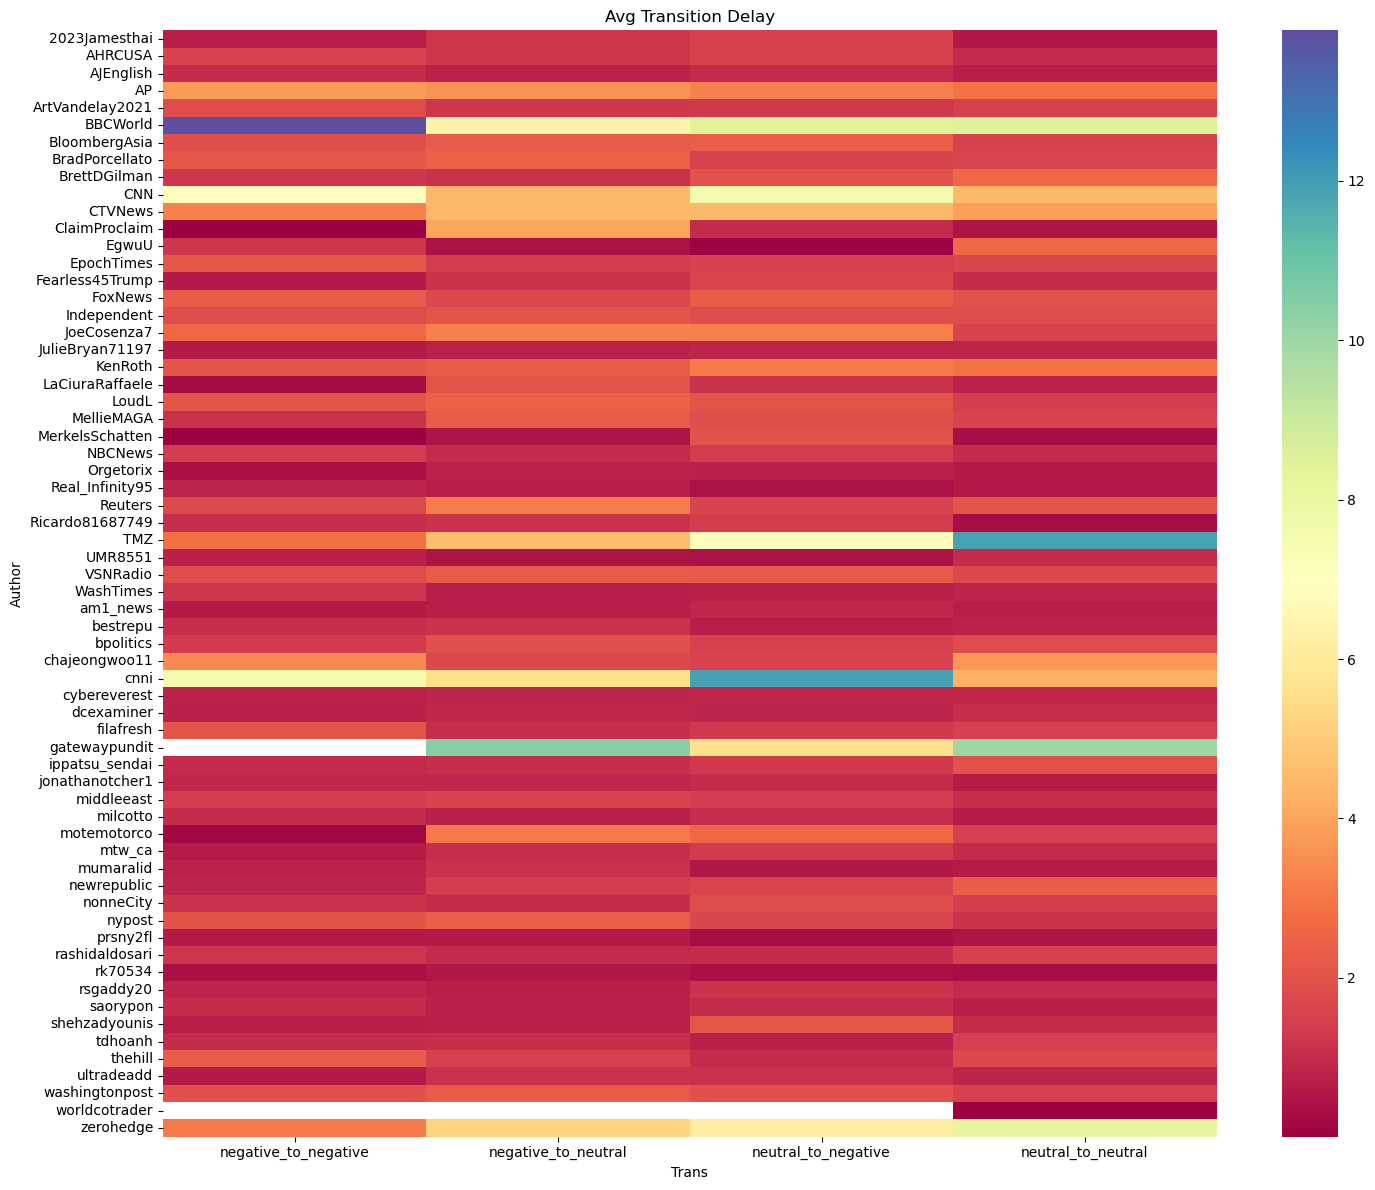

In [12]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(avg_trans_delay, cmap=sns.color_palette("Spectral", as_cmap=True))
plt.title("Avg Transition Delay")
plt.tight_layout()
plt.savefig(f"Average_Transition_Delay_Heatmap_{sentiments}.png")
plt.show()

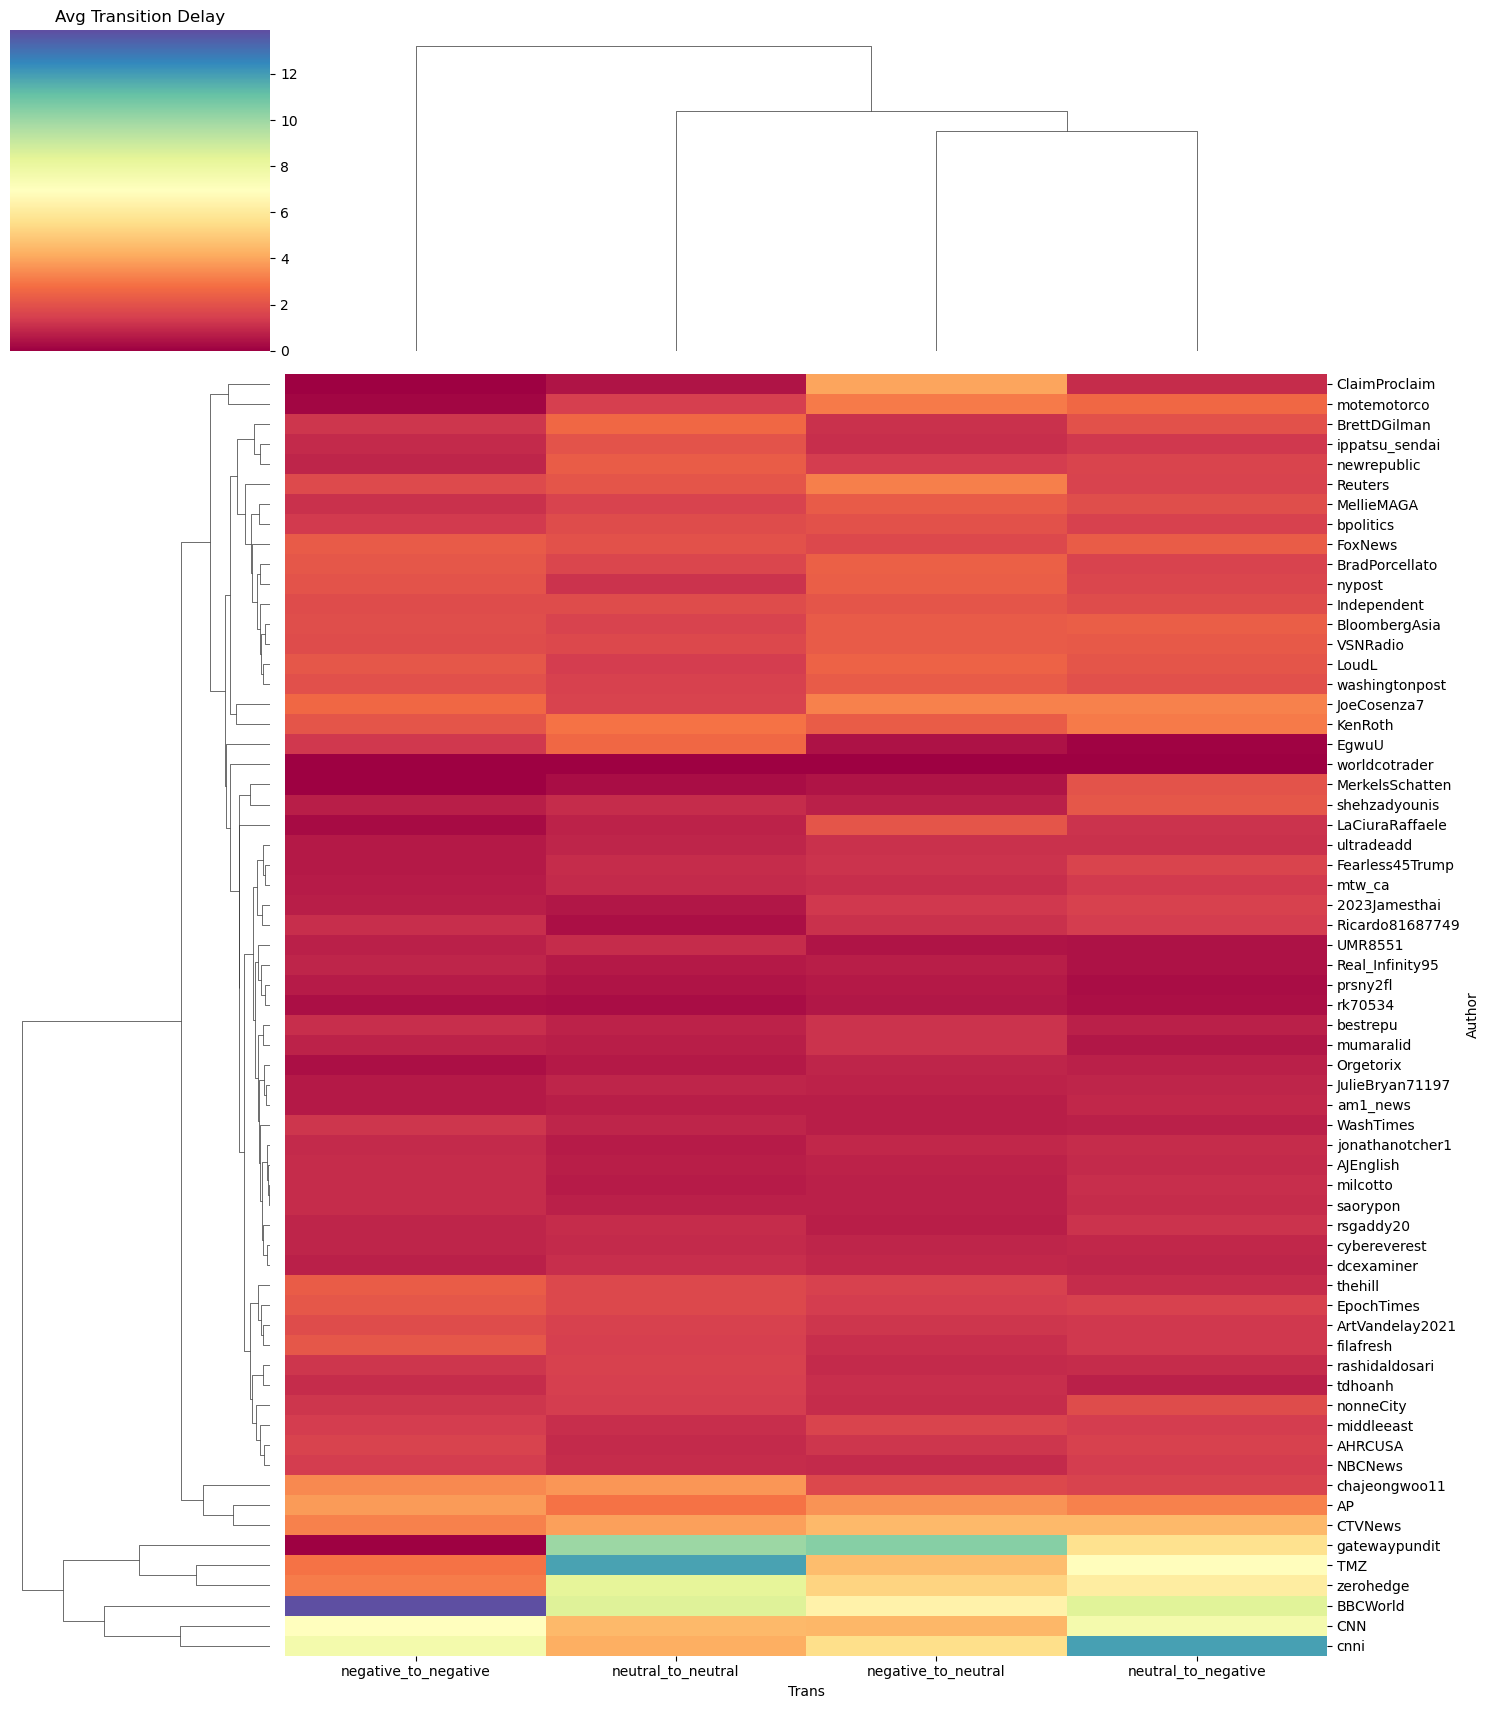

In [13]:
sns.clustermap(avg_trans_delay.fillna(0), figsize=(15,17), cmap=sns.color_palette("Spectral", as_cmap=True))
plt.title("Avg Transition Delay")
plt.tight_layout()
plt.savefig(f"Average_Transition_Delay_Clusterplot_{sentiments}.png")
plt.show()

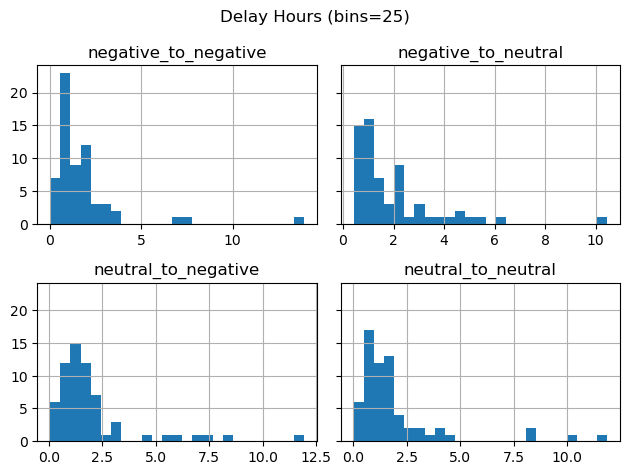

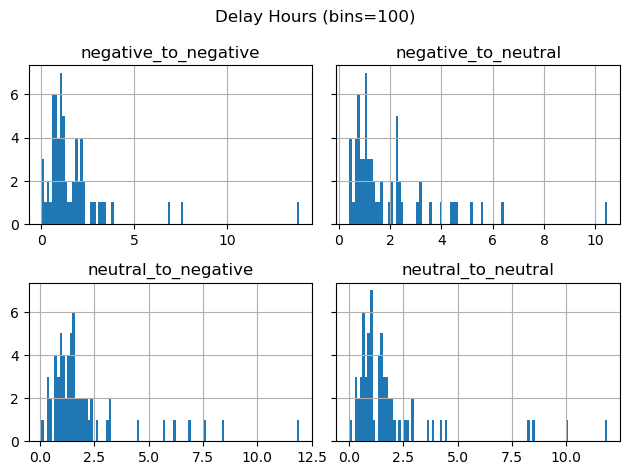

In [14]:
for binv in [25, 100]:
    fig, axs = plt.subplots(2,2, sharey=True)
    for idx, col in enumerate(avg_trans_delay.columns):
        y = idx % 2
        x = idx // 2
        avg_trans_delay[col].hist(bins=binv, ax=axs[x][y])
        axs[x][y].set_title(col)

    plt.suptitle(f"Delay Hours (bins={binv})")
    plt.tight_layout()
    plt.savefig(f"./DelayHoursHistograms_bins{binv}.png")
    plt.show()

## 4. Calculate Marginal Probability

In [15]:
def gcalc(df):
    df["Transitions"] = df["NumericSentiment"].diff()
    df["Trans"] = df[["NumericSentiment", "Transitions"]].apply(lambda row: fdiff_to_transition[row["Transitions"]] if row["Transitions"] in fdiff_to_transition else numeric_to_echo_transitions[row["NumericSentiment"]], axis=1)
    df.dropna(inplace=True)
    return df["Trans"].value_counts().rename("val").rename_axis("Trans") / df.shape[0]

In [16]:
gcalcs = datadf[["Author", "NumericSentiment"]].groupby("Author").apply(lambda gdf: gcalc(gdf)).reset_index()
gcalcs

,Author,Trans,val
0,2023Jamesthai,neutral_to_neutral,0.378667
1,2023Jamesthai,negative_to_neutral,0.224000
2,2023Jamesthai,neutral_to_negative,0.221333
3,2023Jamesthai,negative_to_negative,0.176000
4,AHRCUSA,negative_to_negative,0.314050
...,...,...,...
247,worldcotrader,neutral_to_neutral,1.000000
248,zerohedge,neutral_to_neutral,0.534884
249,zerohedge,negative_to_neutral,0.209302
250,zerohedge,neutral_to_negative,0.209302


In [17]:
gcalcs = gcalcs.pivot(index="Author", columns="Trans", values="val")
gcalcs.to_csv(f"./outputs/gcalcs_{sentiments}.csv")
gcalcs

Trans,negative_to_negative,negative_to_neutral,neutral_to_negative,neutral_to_neutral
Author,,,,
2023Jamesthai,0.176000,0.224000,0.221333,0.378667
AHRCUSA,0.314050,0.239669,0.243802,0.202479
AJEnglish,0.139535,0.218605,0.218605,0.423256
AP,0.419355,0.225806,0.236559,0.118280
ArtVandelay2021,0.192771,0.253012,0.253012,0.301205
...,...,...,...,...
thehill,0.144279,0.233831,0.233831,0.388060
ultradeadd,0.194366,0.191549,0.188732,0.425352
washingtonpost,0.222222,0.257310,0.263158,0.257310


In [18]:
marginal_df = pd.DataFrame()
for sntmnt in sentiments.split("_"):
    cols = [col for col in gcalcs.columns if col.split("_")[0] == sntmnt]
    sum_val = gcalcs[cols].sum(axis=1).rename(f"{sntmnt}_sum")
    marginal_df = marginal_df.join( gcalcs[cols].div(sum_val, axis=0), how="outer")

marginal_df

,negative_to_negative,negative_to_neutral,neutral_to_negative,neutral_to_neutral
Author,,,,
2023Jamesthai,0.440000,0.560000,0.368889,0.631111
AHRCUSA,0.567164,0.432836,0.546296,0.453704
AJEnglish,0.389610,0.610390,0.340580,0.659420
AP,0.650000,0.350000,0.666667,0.333333
ArtVandelay2021,0.432432,0.567568,0.456522,0.543478
...,...,...,...,...
thehill,0.381579,0.618421,0.376000,0.624000
ultradeadd,0.503650,0.496350,0.307339,0.692661
washingtonpost,0.463415,0.536585,0.505618,0.494382


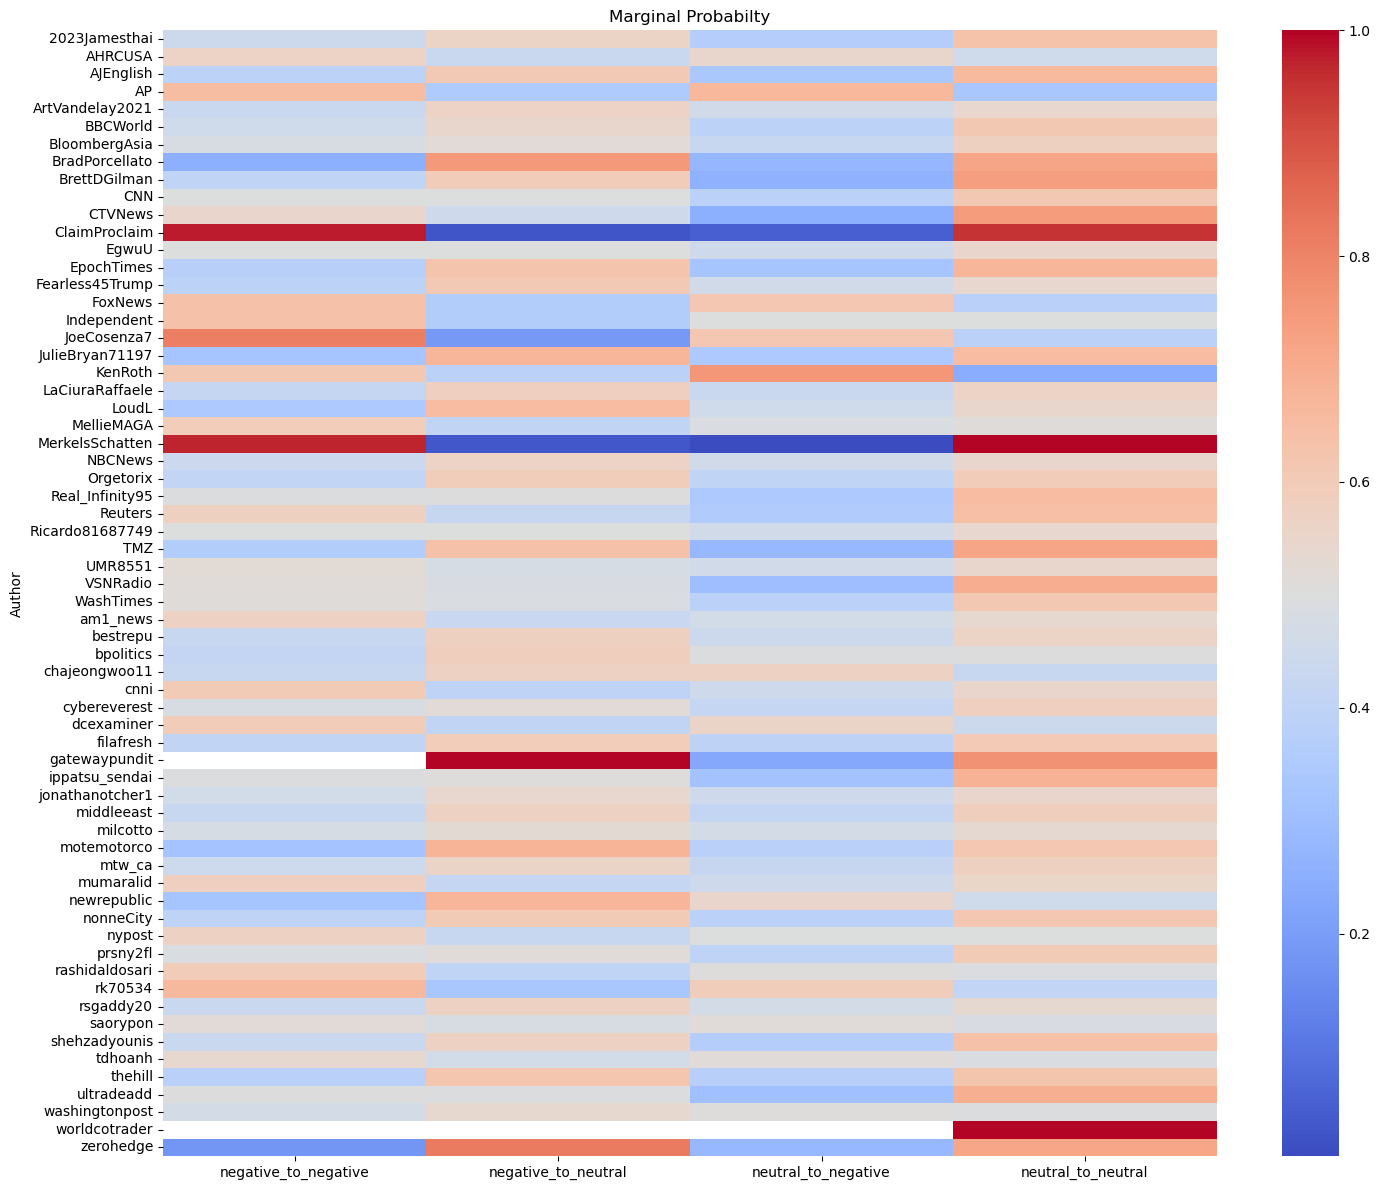

In [19]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(marginal_df, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.title("Marginal Probabilty")
plt.tight_layout()
plt.savefig(f"Marginal_Probability_Heatmap_{sentiments}.png")
plt.show()

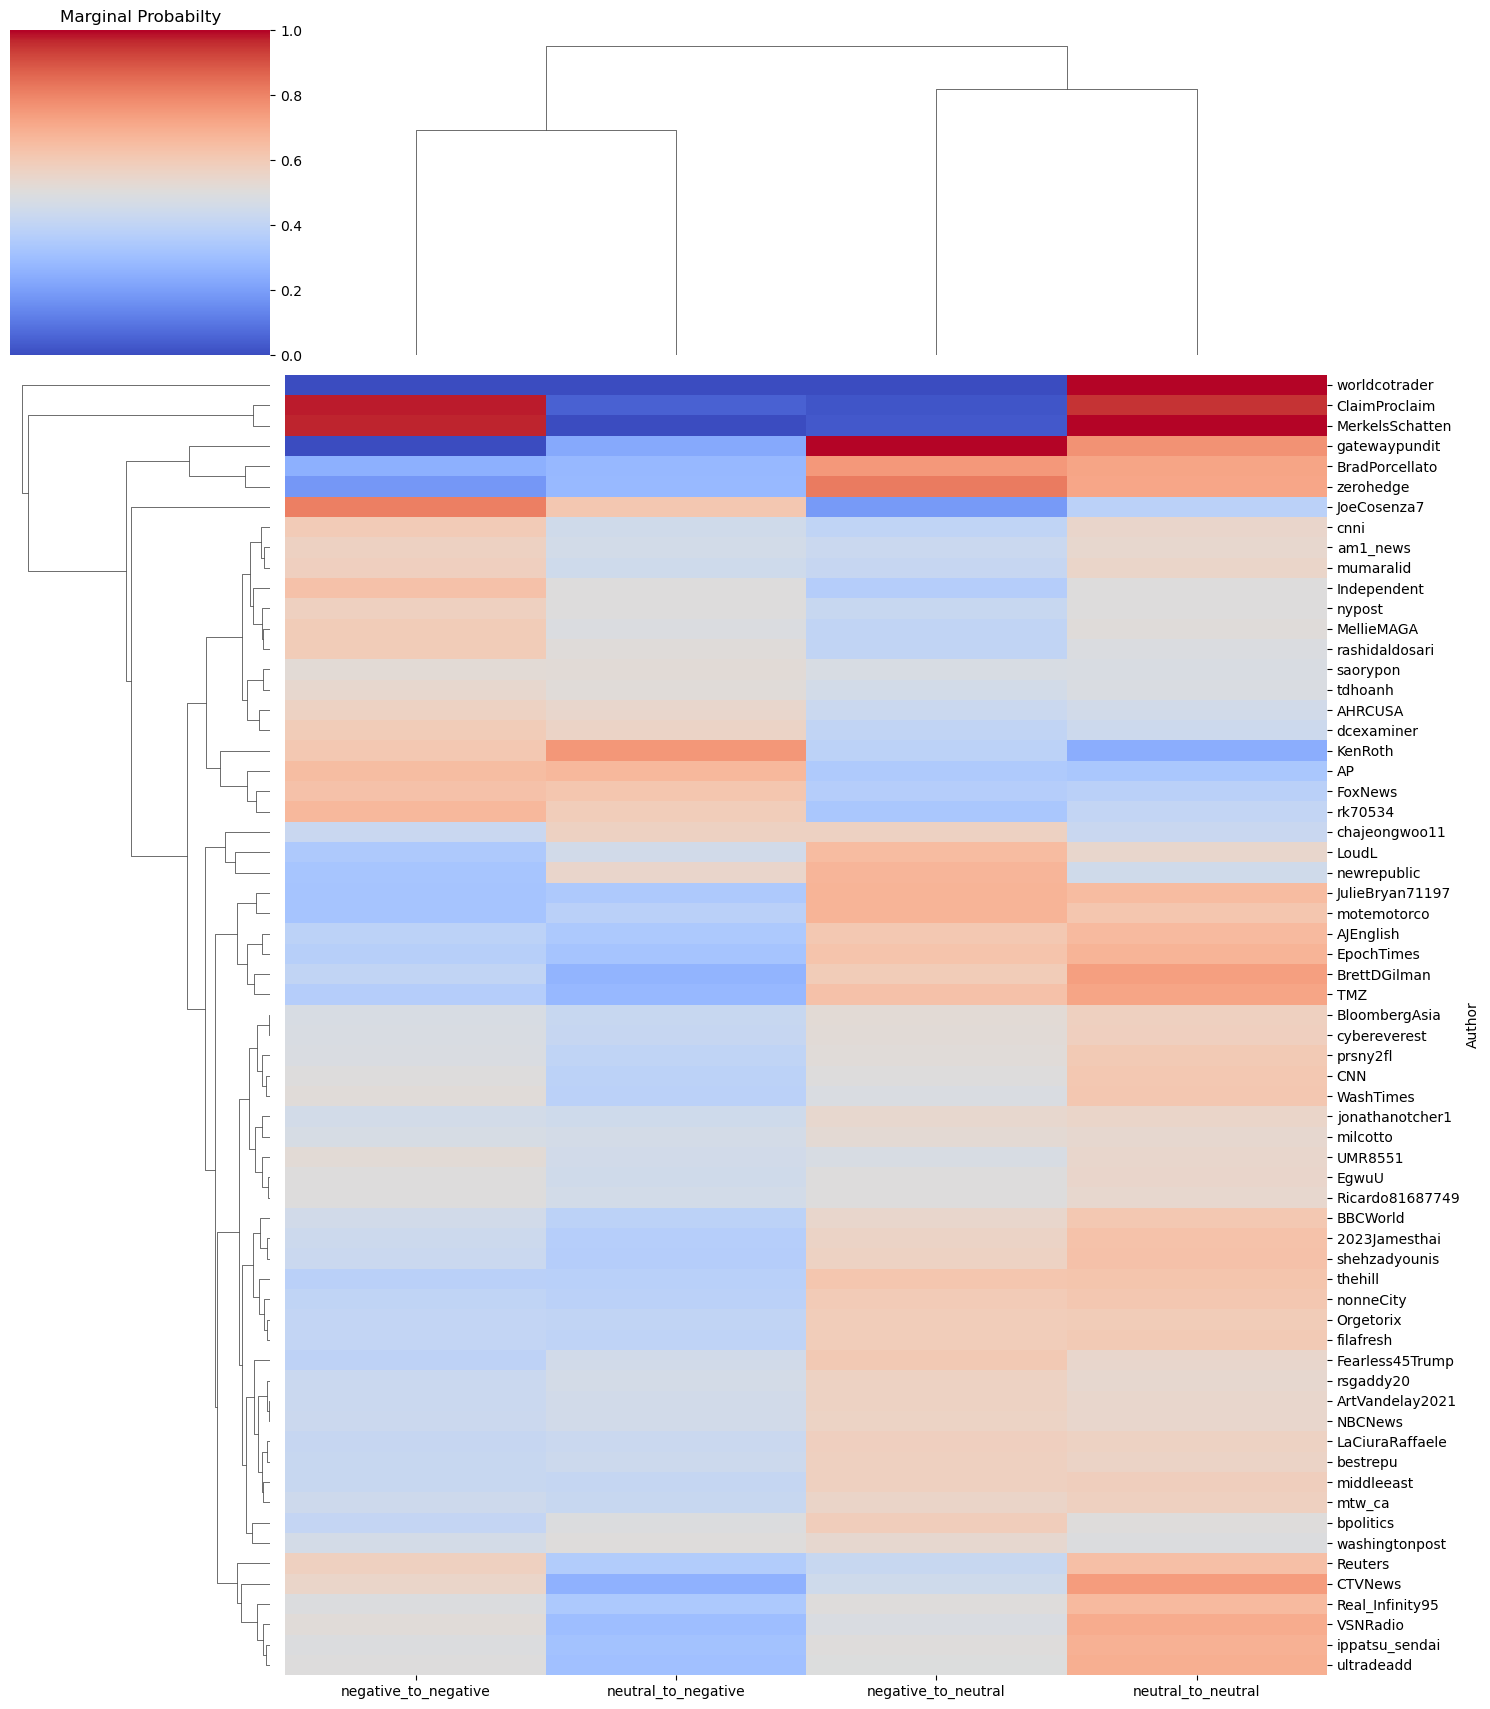

In [20]:
# fig, ax = plt.subplots(figsize=(15,12))
sns.clustermap(marginal_df.fillna(0), figsize=(15,17), cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.title("Marginal Probabilty")
plt.tight_layout()
plt.savefig(f"Marginal_Probability_Clusterplot_cw_{sentiments}.png")
plt.show()

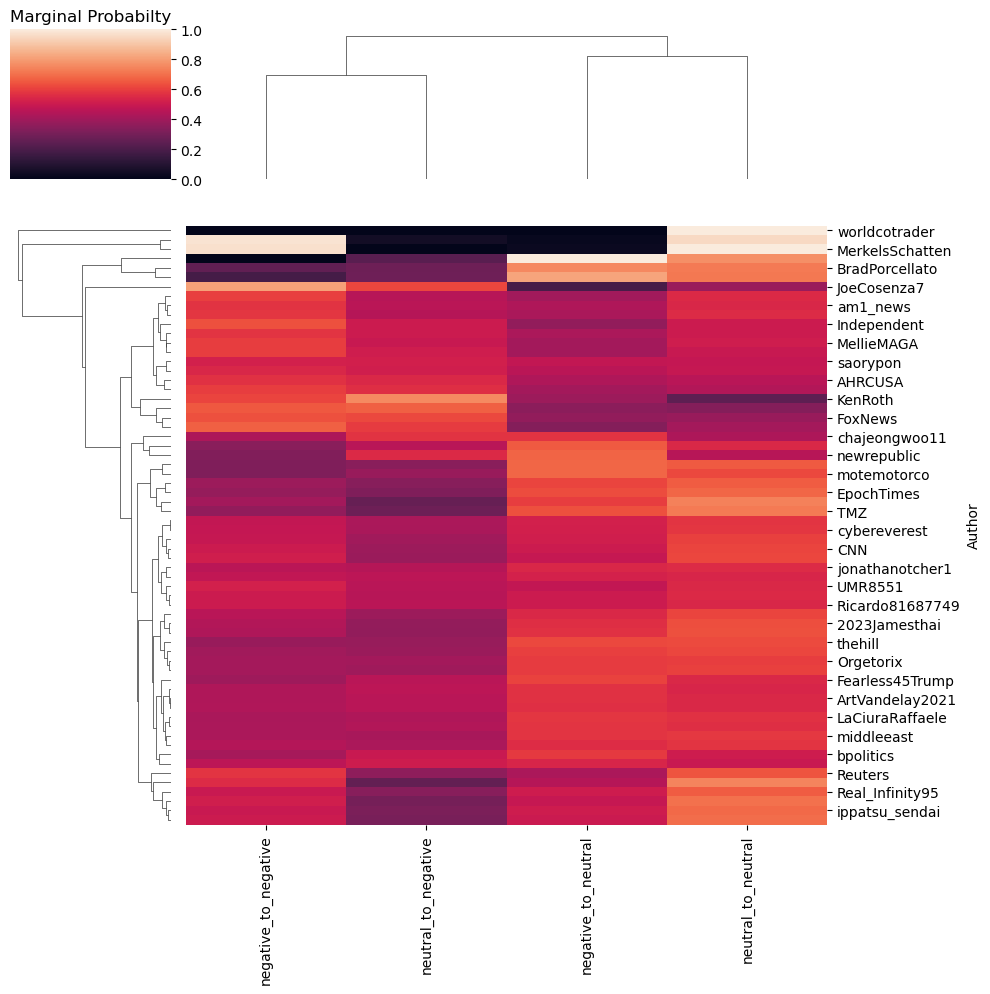

In [21]:
# fig, ax = plt.subplots(figsize=(15,12))
sns.clustermap(marginal_df.fillna(0))#, cmap=sns.color_palette("coolwarm", as_cmap=True))
plt.title("Marginal Probabilty")
plt.tight_layout()
plt.savefig(f"Marginal_Probability_Clusterplot_def_{sentiments}.png")
plt.show()

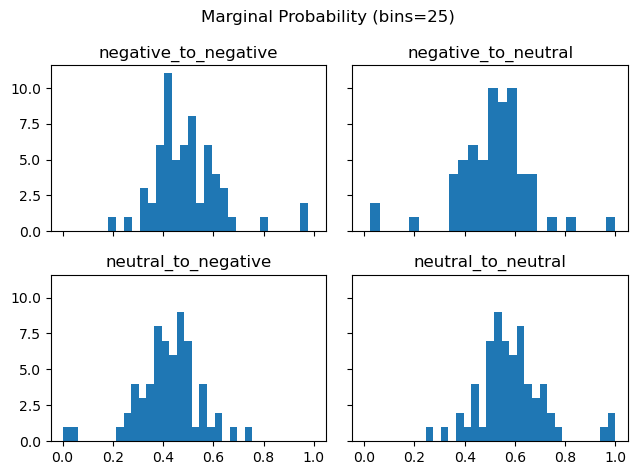

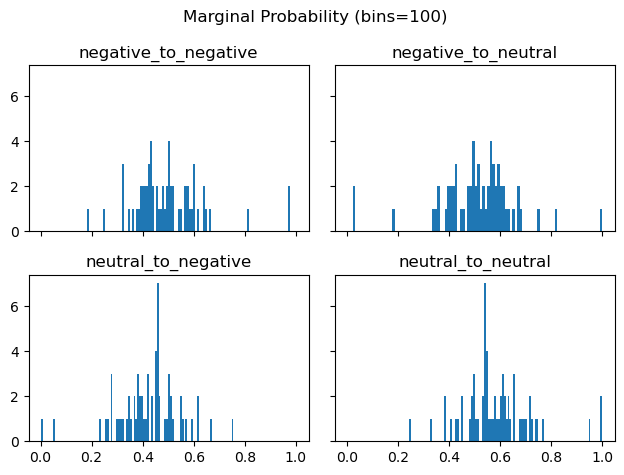

In [22]:
for binv in [25, 100]:
    fig, axs = plt.subplots(2,2, sharey=True, sharex=True)
    for idx, col in enumerate(marginal_df.columns):
        y = idx % 2
        x = idx // 2
        marginal_df[col].hist(bins=binv, ax=axs[x][y])
        axs[x][y].set_title(col)
        axs[x][y].grid(False)
    
    plt.suptitle(f"Marginal Probability (bins={binv})")
    
    plt.tight_layout()
    plt.savefig(f"./MarginalProbsHistograms_bins{binv}.png")
    plt.show()